This is for Chapter 15 and Week 10 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logit
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Waffle divorce problems

In [6]:
DATA = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/'
df_divorce = pd.read_csv(DATA + 'WaffleDivorce.csv', sep=';')
df_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<IPython.core.display.Javascript object>

In [17]:
df_divorce['Marriage'].max()

30.7

<IPython.core.display.Javascript object>

why scale standard error by dividing against standard deviation of `divorce`?

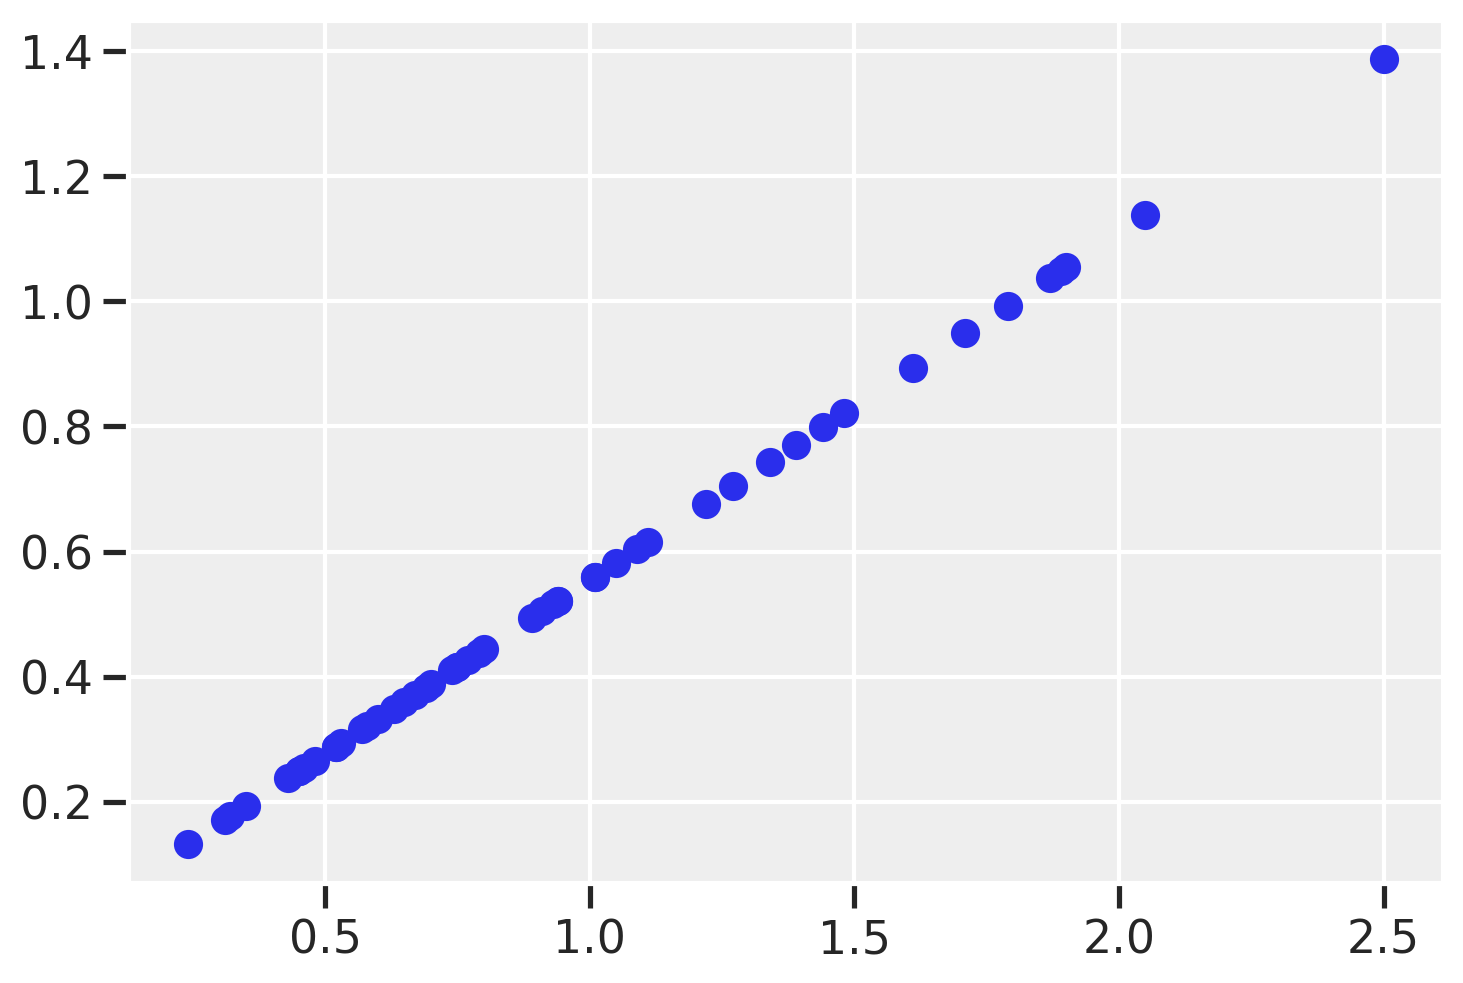

<IPython.core.display.Javascript object>

In [11]:
plt.scatter(df_divorce['Divorce SE'], (df_divorce['Divorce SE'] / np.std(df_divorce['Divorce'])))

In [7]:
df_divorce['Divorce SE'] / np.std(df_divorce['Divorce'])

0     0.438277
1     1.137301
2     0.410538
3     0.676833
4     0.133147
5     0.521494
6     0.427181
7     0.771145
8     1.048536
9     0.177530
10    0.321773
11    0.704572
12    0.582520
13    0.249651
14    0.349512
15    0.504851
16    0.604711
17    0.416086
18    0.493755
19    0.821076
20    0.382799
21    0.288486
22    0.294034
23    0.332868
24    0.560329
25    0.371703
26    0.948675
27    0.521494
28    0.893197
29    0.255199
30    0.615807
31    0.171982
32    0.266295
33    0.798884
34    0.249651
35    0.560329
36    0.443825
37    0.238556
38    0.993058
39    0.388347
40    1.386952
41    0.416086
42    0.194173
43    0.515946
44    1.037440
45    0.288486
46    0.360608
47    0.743406
48    0.316225
49    1.054083
Name: Divorce SE, dtype: float64

<IPython.core.display.Javascript object>

In [8]:
np.std(df_divorce['Divorce SE'])

0.5200872619089992

<IPython.core.display.Javascript object>

# 15M2

Reconsider the primate milk missing data example from the chapter. This time, assign B a
distribution that is properly bounded between zero and 1. A beta distribution, for example, is a good
choice.

Ki ∼ Normal(μi, σ) [distributionforoutcome k]
μi = α + βBBi + βM log Mi [linearmodel]
Bi ∼ Normal(ν,σB) [distributionforobs/missing B]
α ∼ Normal(0, 0.5)
βB ∼ Normal(0, 0.5)
βM ∼ Normal(0, 0.5)
σ ∼ Exponential(1)
ν ∼ Normal(0.5, 1)
σB ∼ Exponential(1)

In [23]:
!ls /Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/

Howell1.csv           cars.csv              milk.csv
Kline                 chimpanzees.csv       oxboys.csv
Kline2.csv            eagles.csv            reedfrogs.csv
Trolley.csv           elephants.csv         rugged.csv
UCBadmit.csv          fish.csv              salamanders.csv
WaffleDivorce.csv     hurricanes.csv        tulips.csv
bangladesh.csv        islandsDistMatrix.csv


<IPython.core.display.Javascript object>

In [24]:
DATA = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/'
df_primates = pd.read_csv(DATA + 'milk.csv', sep=';')
df_primates.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


<IPython.core.display.Javascript object>

In [147]:
# Check neocortex missing values
df_primates['neocortex.perc'].isna().sum()

12

<IPython.core.display.Javascript object>

In [28]:
df_primates['k_std'] = standardize(df_primates['kcal.per.g'])
df_primates['m_std'] = standardize(df_primates['mass'])

<IPython.core.display.Javascript object>

mu value:  0.5


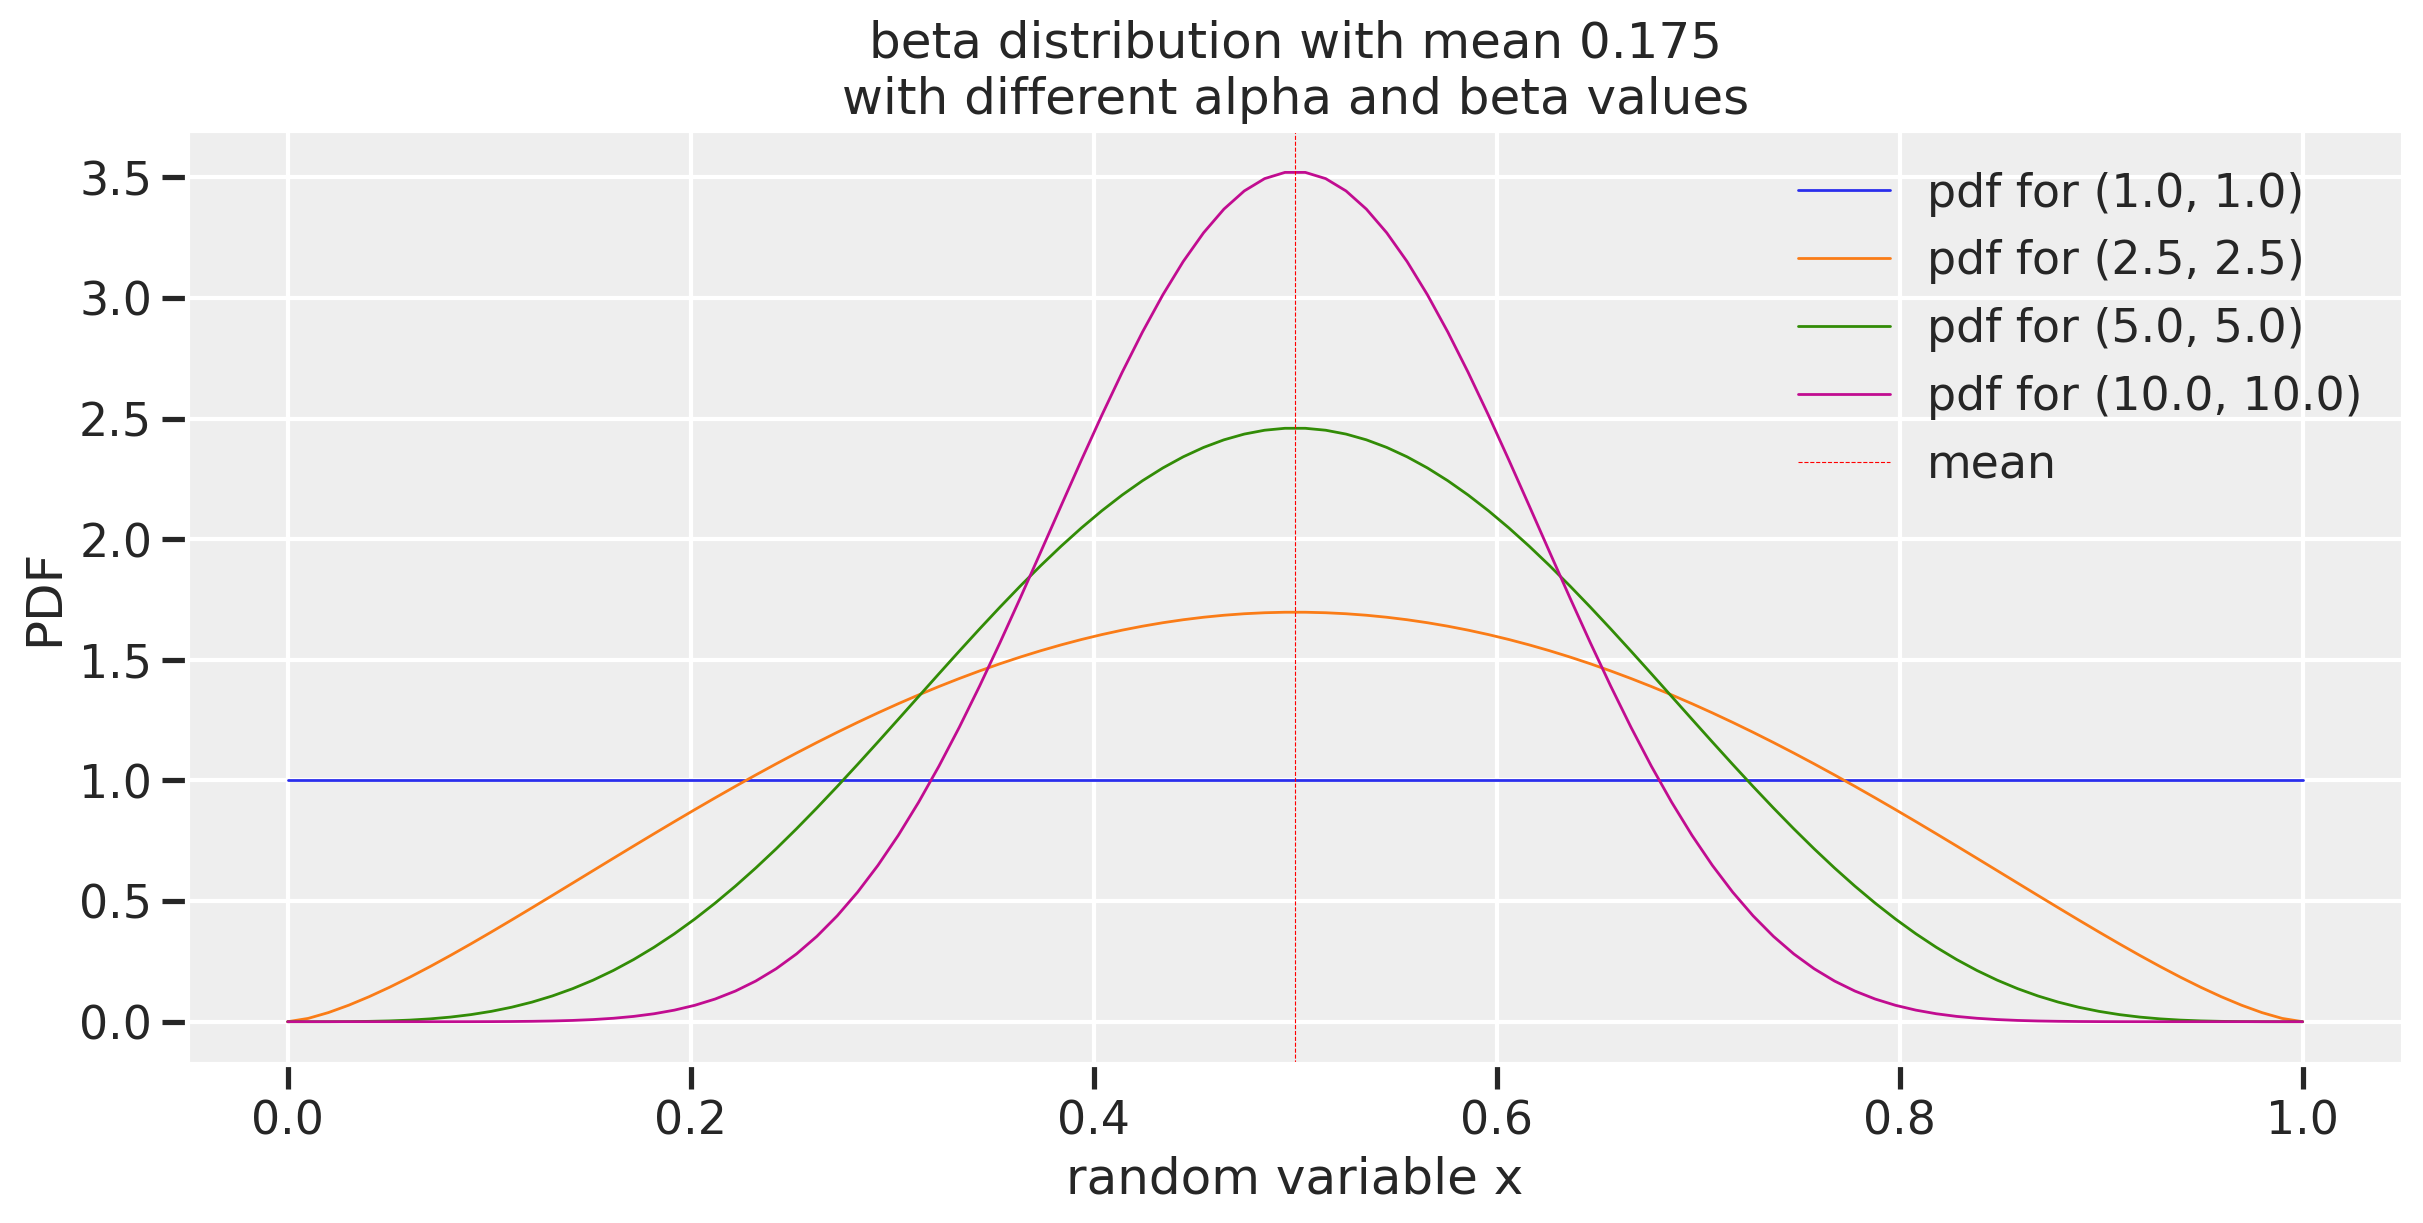

<IPython.core.display.Javascript object>

In [43]:
from scipy.stats import beta

# mu is the midpoint between the two talent rates of the original problem
mu = 0.5  
print("mu value: ", mu)

# Generate different values of alpha (a) and beta (b)
n_list= [2, 5, 10, 20]

f, ax1 = plt.subplots(figsize=(12,6))
for n in n_list:
    #a = round(mu*n)
    a = (mu*n)
    b = n-a

    x = np.linspace(beta.ppf(0.00, a, b),
                    beta.ppf(1.00, a, b), 100)
    this_label = 'pdf for (' + str(a) + ', ' + str(b) + ')'

    ax1.plot(x, beta.pdf(x, a, b),
                lw=1, label=this_label)
        
ax1.axvline(mu, lw=0.4, color='red', linestyle='dashed', label='mean')
ax1.set_title('beta distribution with mean 0.175\nwith different alpha and beta values')
ax1.set_xlabel('random variable x')
ax1.set_ylabel('PDF')
ax1.legend();

In [46]:
M = df_primates['m_std']

with pm.Model() as m15m2:

    # hyperpriors (?)
    #nu = pm.Beta("nu", alpha=5, beta=5)
    nu = pm.Normal("nu", 0.5, 1)
    sigma_b = pm.Exponential("sigma_b", 1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    beta_b = pm.Normal("beta_b", 0, 0.5)
    beta_m = pm.Normal("beta_m", 0, 0.5)
    
    # B = pm.Beta("B", nu, sigma_b)
    B = pm.Normal("B", nu, sigma_b)
    
    # linear model
    mu = a + beta_b*B + beta_m*np.log(M)

    # likelihood
    K = pm.Normal("K", mu, sigma, observed=df_primates['k_std'])

    # sample
    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'nu': array(0.5), 'sigma_b_log__': array(-0.36651292), 'a': array(0.), 'sigma_log__': array(-0.36651292), 'beta_b': array(0.), 'beta_m': array(0.), 'B': array(0.5)}

Initial evaluation results:
nu              -0.92
sigma_b_log__   -1.06
a               -0.23
sigma_log__     -1.06
beta_b          -0.23
beta_m          -0.23
B               -0.55
K                 NaN
Name: Log-probability of test_point, dtype: float64

<IPython.core.display.Javascript object>

# 15M4

Simulate the following DAG: X -> Y -> Z. 

Now build a model predicting Y using both X and Z. What is the confound that arises?

$$ Y =\alpha + \beta_1X + \beta_2Z $$

In [47]:
X = np.random.normal(0, 1, size=100)
Y = np.random.normal(0, 1, size=100)*X + 0.25
Z = np.random.normal(0, 1, size=100)*Y + 1

df = pd.DataFrame(np.array([X,Y,Z]).reshape(100,3))
df.columns = ['X', 'Y', 'Z']

<IPython.core.display.Javascript object>

In [51]:
df.iloc[:, 0:2].corr()

,X,Y
X,1.000000,0.167876
Y,0.167876,1.000000


<IPython.core.display.Javascript object>

In [52]:
df.iloc[:, 1:3].corr()

,Y,Z
Y,1.000000,0.284929
Z,0.284929,1.000000


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


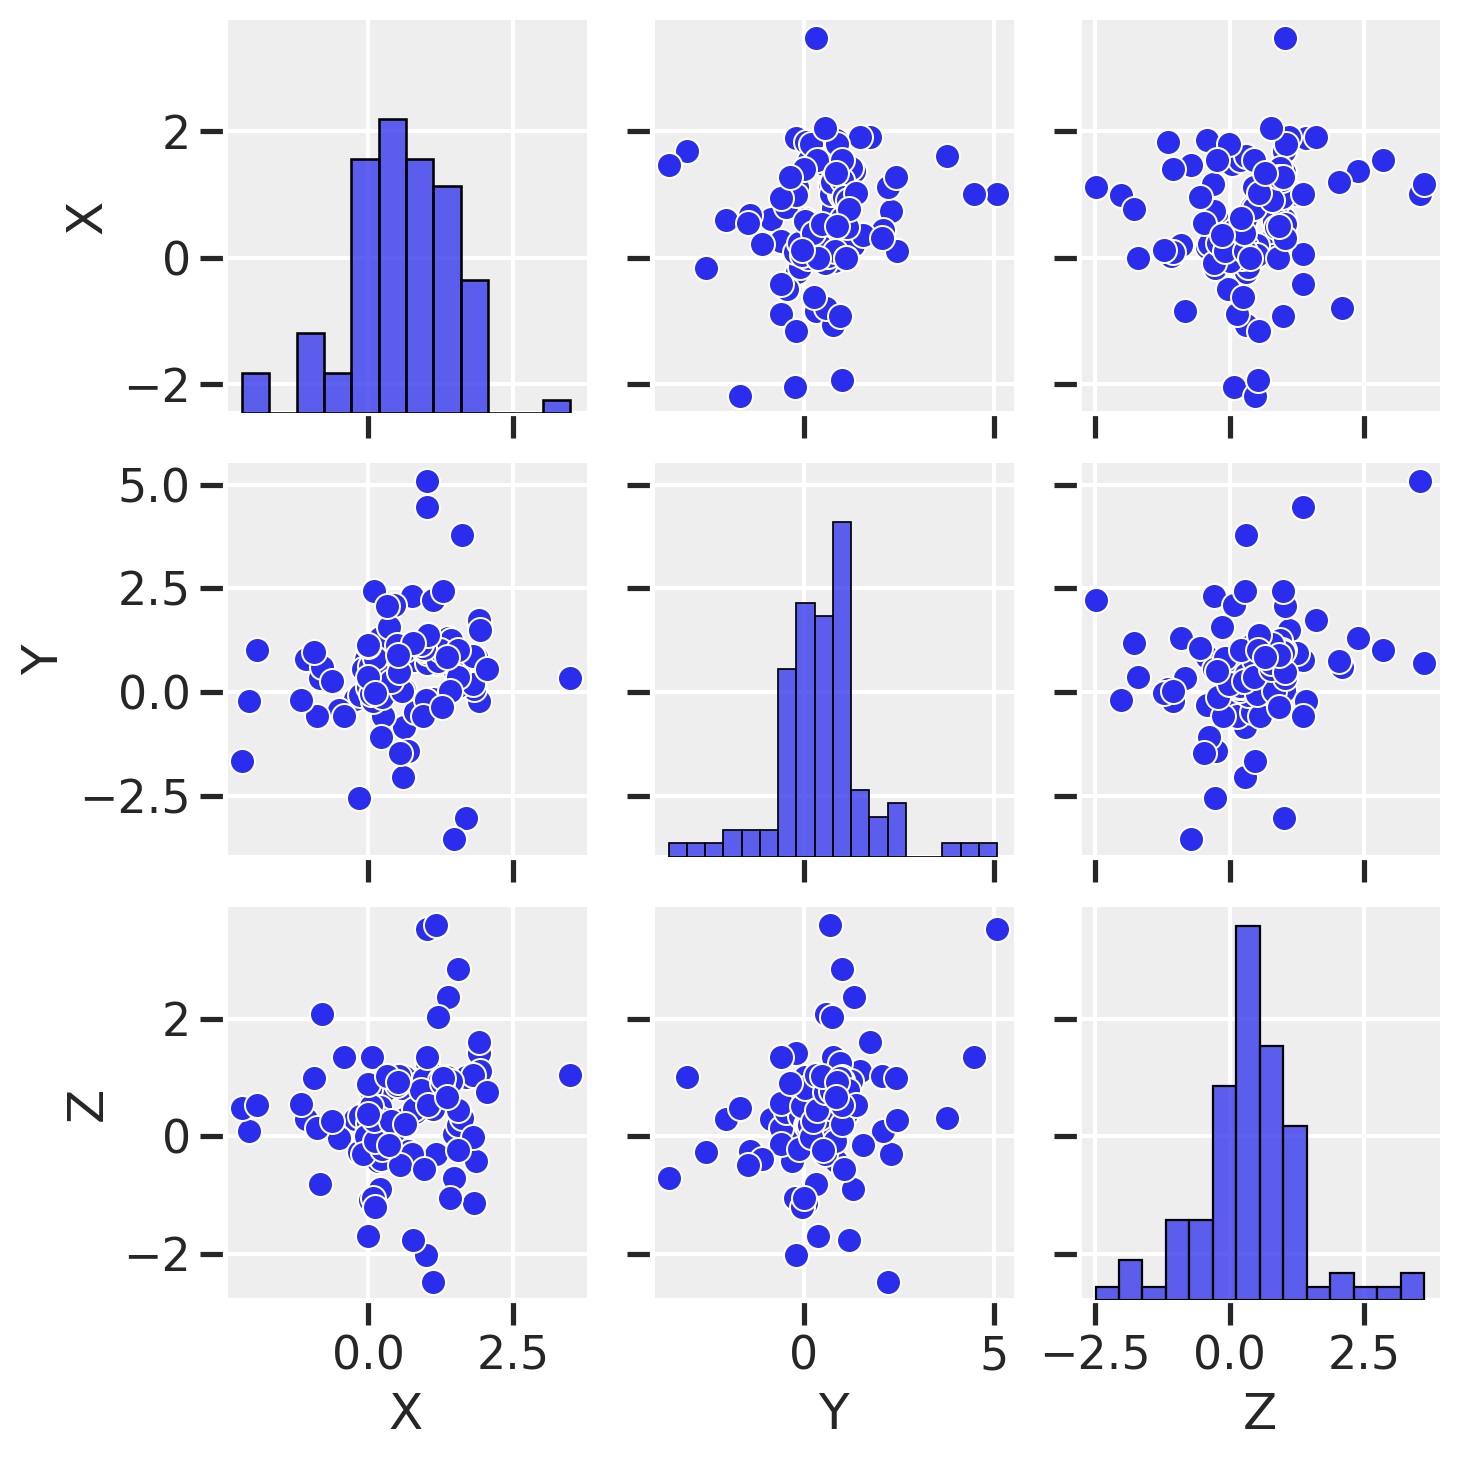

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(df)

In [ ]:
sns.

In [ ]:
with pm.Model() as m1:

    # prior
    a = pm.Normal()


    # likelihood?


    

### Simulation from McElreath's causal salad lecture

McElreath's [causal salad](https://github.com/rmcelreath/causal_salad_2021/blob/main/1_causal_salad.r) example.

In [ ]:
# 

## Back to Section 3.3

I still didn't understand above, so he explitly goes over simulation to simulate prediction here.

In [53]:
from scipy.stats import binom

<IPython.core.display.Javascript object>

Probability of observing 0, 1, 2 water for three tosses of the globe.

In [126]:
# dbinom( 0:2,size=2,prob=0.7)
# n = tosses of the globe
# k = list of desired observations (range(3)) is 0,1,2
binom.pmf(k=[0,1,2], n=2, p=0.7)


array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

In [127]:
# 0 and 1
binom.pmf(range(2), n=2, p=0.7)

array([0.09, 0.42])

<IPython.core.display.Javascript object>

In [133]:
# can confuse self if you put obs out of order
binom.pmf([0, 1, 2, 3], n=2, p=0.7)

array([0.09, 0.42, 0.49, 0.  ])

<IPython.core.display.Javascript object>

In [141]:
# Use rvs to make dummy observations
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 2, 1, 0, 1, 1, 1, 0, 2, 2])

<IPython.core.display.Javascript object>

In [142]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=10**5)

<IPython.core.display.Javascript object>

In [145]:
# see if counts are in proportion
pd.Series(dummy_w).value_counts() / 10**5

2    0.48860
1    0.42065
0    0.09075
dtype: float64

<IPython.core.display.Javascript object>

(array([ 9075.,     0.,     0.,     0.,     0., 42065.,     0.,     0.,
            0., 48860.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

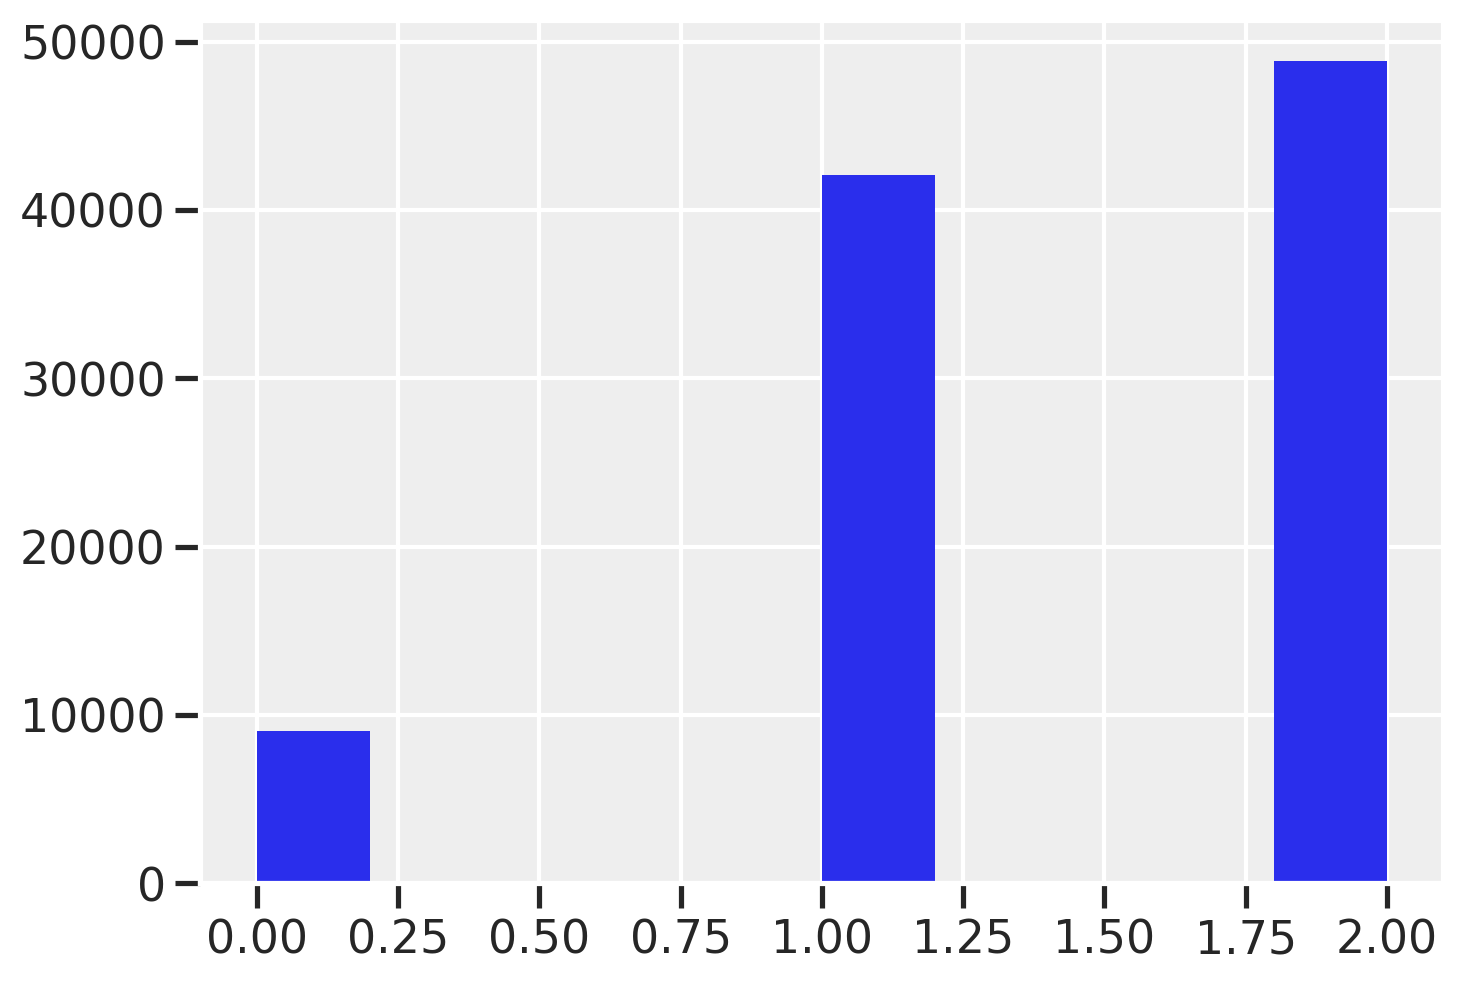

<IPython.core.display.Javascript object>

In [146]:
plt.hist(pd.Series(dummy_w))

# Question 3 (15H7)

This is a hard problem, so don’t feel bad if you struggle with it. Getting a piece
of the solution is good. It might seem arbitrary at first. But it has a similar structure
to a lot of problems in biology, from genetics to archaeology to the comparative
method. It is likely possible for you to quickly intuit a reasonable answer. Justifying
that answer with probability theory is the problem.

Some lad named Andrew made an eight-sided spinner. He wanted to know if it
is fair. So he spun it a bunch of times, recording the counts of each value. Then he
accidentally spilled coffee over the 4s and 5s. The surviving data are:

```
Value      1  2  3  4  5  6  7  8
Frequency 18 19 22 NA NA 19 20 22
```

Your job is to impute the two missing values (the NA values) in the table above.
Andrew doesn’t remember how many times he spun the spinner. So you will have to
assign a prior distribution for the total number of spins and then marginalize over
the unknown total. Andrew is not sure the spinner is fair (every value is equally
likely), but he’s confident that none of the values is twice as likely as any other. Use a
Dirichlet distribution to capture this prior belief. Plot the joint posterior distribution
of 4s and 5s.

Concepts:

- Dirichelet distribution
- Bayesian imputation for missing values

## Data setup

In [6]:
# I'll use Python 0 indexing for the value
df_spinner = pd.DataFrame(
    {"value": range(8), "frequency": [18, 19, 22, None, None, 19, 20, 22]}
)

df_spinner

,value,frequency
0,0,18.0
1,1,19.0
2,2,22.0
3,3,NaN
4,4,NaN
5,5,19.0
6,6,20.0
7,7,22.0


<IPython.core.display.Javascript object>

## Model equation

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>